# **KModes Algorithm to predict Shelf-Life Clusters**
> Following Clusters are classified into : 
  1. Poor - 2
  2. Average - 1
  3. Good - 0


**Importing all the crucial libraries**

In [1]:
import pandas as pd
import numpy as np
!pip install kmodes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
! git clone https://github.com/vaishakhshetty/STEER-ML.git

Cloning into 'STEER-ML'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 58 (delta 18), reused 45 (delta 11), pack-reused 0
Unpacking objects: 100% (58/58), done.


In [3]:
ls

sample_data/  STEER-ML/


## Data Preprocessing

In [4]:
data = pd.read_csv('/content/STEER-ML/data/V5_Dummy-Data.csv')

In [5]:
data.head(5)

,Unnamed: 0,Device_type,Device_ID,Device_brand,Device_model,Manufacture_Date,Allocation_Date,Assessment_Date,Age(days),device_in_use,water_damage,device_responsive,battery_health,Usage(hrs),Latency(ms)
0,0,Feature Phone,41181218,Nokia,6300,2016-12-05,2021-07-26,2022-01-13,1865,No,No,No,Poor,2.86,Poor
1,1,Laptop,33295510,Lenovo,Ideapad,2019-02-19,2021-05-28,2022-01-08,1054,No,No,Yes,Good,19.10,Good
2,2,Feature Phone,44719050,Nokia,225,2014-03-08,2021-04-16,2022-01-31,2886,No,Yes,No,Poor,4.34,Poor
3,3,Feature Phone,75689223,Samsung,6300,2014-12-01,2021-05-20,2022-01-03,2590,No,No,Yes,Poor,4.60,Poor
4,4,Laptop,38511752,Apple,MacBook,2015-12-06,2021-05-26,2022-01-23,2240,No,No,No,Average,6.89,Average


In [6]:
data = data.drop(['Unnamed: 0','Device_ID'], axis = 1)
data.head()

,Device_type,Device_brand,Device_model,Manufacture_Date,Allocation_Date,Assessment_Date,Age(days),device_in_use,water_damage,device_responsive,battery_health,Usage(hrs),Latency(ms)
0,Feature Phone,Nokia,6300,2016-12-05,2021-07-26,2022-01-13,1865,No,No,No,Poor,2.86,Poor
1,Laptop,Lenovo,Ideapad,2019-02-19,2021-05-28,2022-01-08,1054,No,No,Yes,Good,19.10,Good
2,Feature Phone,Nokia,225,2014-03-08,2021-04-16,2022-01-31,2886,No,Yes,No,Poor,4.34,Poor
3,Feature Phone,Samsung,6300,2014-12-01,2021-05-20,2022-01-03,2590,No,No,Yes,Poor,4.60,Poor
4,Laptop,Apple,MacBook,2015-12-06,2021-05-26,2022-01-23,2240,No,No,No,Average,6.89,Average


In [7]:
# join two attribute columns - Device Brand and Device Model >
data['Device_list'] = data[['Device_brand', 'Device_model']].values.tolist()
data['Device'] = data['Device_list'].apply(' '.join)

In [8]:
data = data.drop(['Device_list', 'Device_brand', 'Device_model'], axis = 1)
data.head(5)

,Device_type,Manufacture_Date,Allocation_Date,Assessment_Date,Age(days),device_in_use,water_damage,device_responsive,battery_health,Usage(hrs),Latency(ms),Device
0,Feature Phone,2016-12-05,2021-07-26,2022-01-13,1865,No,No,No,Poor,2.86,Poor,Nokia 6300
1,Laptop,2019-02-19,2021-05-28,2022-01-08,1054,No,No,Yes,Good,19.10,Good,Lenovo Ideapad
2,Feature Phone,2014-03-08,2021-04-16,2022-01-31,2886,No,Yes,No,Poor,4.34,Poor,Nokia 225
3,Feature Phone,2014-12-01,2021-05-20,2022-01-03,2590,No,No,Yes,Poor,4.60,Poor,Samsung 6300
4,Laptop,2015-12-06,2021-05-26,2022-01-23,2240,No,No,No,Average,6.89,Average,Apple MacBook


In [9]:
data['Usage_range'] = pd.cut(data['Usage(hrs)'], [0, 3, 5, 7, 11, 13, 20], labels=['<3', '3-5', '5-7', '7-11', '11-13', '13>'])
data = data.drop('Usage(hrs)',axis = 1)
data.head(5)

,Device_type,Manufacture_Date,Allocation_Date,Assessment_Date,Age(days),device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Device,Usage_range
0,Feature Phone,2016-12-05,2021-07-26,2022-01-13,1865,No,No,No,Poor,Poor,Nokia 6300,<3
1,Laptop,2019-02-19,2021-05-28,2022-01-08,1054,No,No,Yes,Good,Good,Lenovo Ideapad,13>
2,Feature Phone,2014-03-08,2021-04-16,2022-01-31,2886,No,Yes,No,Poor,Poor,Nokia 225,3-5
3,Feature Phone,2014-12-01,2021-05-20,2022-01-03,2590,No,No,Yes,Poor,Poor,Samsung 6300,3-5
4,Laptop,2015-12-06,2021-05-26,2022-01-23,2240,No,No,No,Average,Average,Apple MacBook,5-7


In [10]:
data['Age_days'] = pd.cut(data['Age(days)'], [0, 300, 500, 700, 1100, 1300, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000], labels=['<300', '300-500', '500-700', '700-1100', '1100-1300', '1300-1700', '1700-2000', '2000-2500', '2500-3000', '3000-3500', '4000-4500', '4500-5000', '5000>'])
data = data.drop('Age(days)',axis = 1)
data.head(5)

,Device_type,Manufacture_Date,Allocation_Date,Assessment_Date,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Device,Usage_range,Age_days
0,Feature Phone,2016-12-05,2021-07-26,2022-01-13,No,No,No,Poor,Poor,Nokia 6300,<3,1300-1700
1,Laptop,2019-02-19,2021-05-28,2022-01-08,No,No,Yes,Good,Good,Lenovo Ideapad,13>,700-1100
2,Feature Phone,2014-03-08,2021-04-16,2022-01-31,No,Yes,No,Poor,Poor,Nokia 225,3-5,2000-2500
3,Feature Phone,2014-12-01,2021-05-20,2022-01-03,No,No,Yes,Poor,Poor,Samsung 6300,3-5,2000-2500
4,Laptop,2015-12-06,2021-05-26,2022-01-23,No,No,No,Average,Average,Apple MacBook,5-7,1700-2000


In [11]:
#Adding a checkpoint 
data_copy = data.copy()

## Exploratory Data Analysis

In [12]:
data.head(10)

,Device_type,Manufacture_Date,Allocation_Date,Assessment_Date,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Device,Usage_range,Age_days
0,Feature Phone,2016-12-05,2021-07-26,2022-01-13,No,No,No,Poor,Poor,Nokia 6300,<3,1300-1700
1,Laptop,2019-02-19,2021-05-28,2022-01-08,No,No,Yes,Good,Good,Lenovo Ideapad,13>,700-1100
2,Feature Phone,2014-03-08,2021-04-16,2022-01-31,No,Yes,No,Poor,Poor,Nokia 225,3-5,2000-2500
3,Feature Phone,2014-12-01,2021-05-20,2022-01-03,No,No,Yes,Poor,Poor,Samsung 6300,3-5,2000-2500
4,Laptop,2015-12-06,2021-05-26,2022-01-23,No,No,No,Average,Average,Apple MacBook,5-7,1700-2000
5,Feature Phone,2019-12-24,2021-02-26,2022-02-12,No,No,Yes,Poor,Poor,Nokia 5310,<3,700-1100
6,Feature Phone,2017-02-05,2021-07-09,2022-01-28,Yes,Yes,Yes,Poor,Poor,Nokia 5310,<3,1300-1700
7,Feature Phone,2018-12-06,2021-07-11,2022-01-07,No,No,Yes,Average,Average,Samsung 125,7-11,1100-1300
8,Smart Phone,2019-01-23,2021-01-06,2022-02-11,Yes,No,Yes,Average,Average,Nokia C20 Plus,7-11,1100-1300
9,Smart Phone,2016-04-02,2021-06-08,2022-02-07,No,No,No,Average,Average,Blackberry Q5,7-11,1700-2000


In [13]:
data.tail(10)

,Device_type,Manufacture_Date,Allocation_Date,Assessment_Date,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Device,Usage_range,Age_days
9990,Feature Phone,2015-12-04,2021-06-03,2022-01-21,No,Yes,No,Good,Good,Samsung 8000,13>,1700-2000
9991,Feature Phone,2019-03-20,2021-07-19,2022-02-14,No,Yes,No,Average,Average,Nokia 225,7-11,700-1100
9992,Feature Phone,2019-03-20,2021-06-19,2022-02-07,Yes,Yes,Yes,Good,Good,Samsung 215,13>,700-1100
9993,Laptop,2019-09-10,2021-05-11,2022-01-17,No,Yes,Yes,Good,Good,Dell Inspiron,13>,700-1100
9994,Feature Phone,2015-11-28,2021-08-03,2022-02-12,No,Yes,Yes,Poor,Poor,Samsung 6300,3-5,1700-2000
9995,Smart Phone,2017-02-14,2021-06-09,2022-01-10,No,No,Yes,Good,Good,Samsung Galaxy S9,13>,1300-1700
9996,Feature Phone,2015-07-03,2021-01-23,2022-01-25,No,No,No,Poor,Poor,Samsung 225,<3,1700-2000
9997,Laptop,2015-05-17,2021-05-10,2022-01-25,No,No,No,Average,Average,HP Probook,7-11,1700-2000
9998,Smart Phone,2017-02-16,2021-02-05,2022-02-03,No,Yes,No,Poor,Poor,Oppo Find 7,3-5,1300-1700
9999,Feature Phone,2019-06-16,2021-07-21,2022-02-07,No,No,No,Average,Average,Nokia 125,7-11,700-1100


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Device_type        10000 non-null  object  
 1   Manufacture_Date   10000 non-null  object  
 2   Allocation_Date    10000 non-null  object  
 3   Assessment_Date    10000 non-null  object  
 4   device_in_use      10000 non-null  object  
 5   water_damage       10000 non-null  object  
 6   device_responsive  10000 non-null  object  
 7   battery_health     10000 non-null  object  
 8   Latency(ms)        10000 non-null  object  
 9   Device             10000 non-null  object  
 10  Usage_range        10000 non-null  category
 11  Age_days           10000 non-null  category
dtypes: category(2), object(10)
memory usage: 801.8+ KB


## Modelling

In [15]:
z = data['Device']

In [16]:
z

0              Nokia 6300
1          Lenovo Ideapad
2               Nokia 225
3            Samsung 6300
4           Apple MacBook
              ...        
9995    Samsung Galaxy S9
9996          Samsung 225
9997           HP Probook
9998          Oppo Find 7
9999            Nokia 125
Name: Device, Length: 10000, dtype: object

In [17]:
data = data.drop(['Device'], axis = 1)

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data = data.apply(le.fit_transform)
data.head()

,Device_type,Manufacture_Date,Allocation_Date,Assessment_Date,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Usage_range,Age_days
0,0,1051,206,12,0,0,0,2,2,5,1
1,1,1837,147,7,0,0,1,1,1,1,6
2,0,66,105,30,0,1,0,2,2,2,3
3,0,332,139,2,0,0,1,2,2,2,3
4,1,691,145,22,0,0,0,0,0,3,2


In [19]:
data = data.drop(['Manufacture_Date', 'Allocation_Date'], axis = 1)
data.head(2)

,Device_type,Assessment_Date,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Usage_range,Age_days
0,0,12,0,0,0,2,2,5,1
1,1,7,0,0,1,1,1,1,6


In [20]:
data = data.drop(['Assessment_Date'], axis = 1)
data.head(2)

,Device_type,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Usage_range,Age_days
0,0,0,0,0,2,2,5,1
1,1,0,0,1,1,1,1,6


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 46571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 46571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 46571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 46571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 46571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 46571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 46571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration:

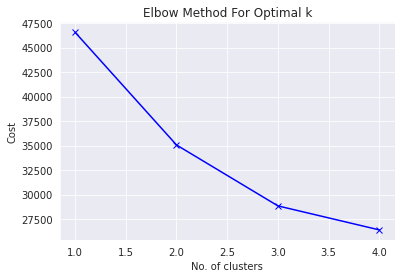

CPU times: user 44.4 s, sys: 3.44 s, total: 47.8 s
Wall time: 51.9 s


In [21]:
# Elbow curve to find optimal K
%%time
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 10, verbose=1, random_state=42)
    kmode.fit_predict(data)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.grid(True)
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=3, init = "random", n_init = 10, verbose=1, random_state=42)
clusters = kmode.fit_predict(data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 568, cost: 28846.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3510, cost: 29219.0
Run 2, iteration: 2/100, moves: 48, cost: 29219.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2256, cost: 32498.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1063, cost: 29064.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 209, cost: 29064.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 4642, cost: 29282.0
Run 6, iteration: 2/100, moves: 1493, cost: 29227.0
Run 6, iteration: 3/100, moves: 273, cost: 29077.0
Run 6, iteration: 4/100, moves: 88, cost: 29077.0
Init: i

In [23]:
clusters

array([2, 0, 2, ..., 1, 2, 1], dtype=uint16)

In [24]:
data.insert(0, "Cluster", clusters, True)
data.head()

,Cluster,Device_type,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Usage_range,Age_days
0,2,0,0,0,0,2,2,5,1
1,0,1,0,0,1,1,1,1,6
2,2,0,0,1,0,2,2,2,3
3,0,0,0,0,1,2,2,2,3
4,1,1,0,0,0,0,0,3,2


In [25]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Device_type        10000 non-null  object  
 1   Manufacture_Date   10000 non-null  object  
 2   Allocation_Date    10000 non-null  object  
 3   Assessment_Date    10000 non-null  object  
 4   device_in_use      10000 non-null  object  
 5   water_damage       10000 non-null  object  
 6   device_responsive  10000 non-null  object  
 7   battery_health     10000 non-null  object  
 8   Latency(ms)        10000 non-null  object  
 9   Device             10000 non-null  object  
 10  Usage_range        10000 non-null  category
 11  Age_days           10000 non-null  category
dtypes: category(2), object(10)
memory usage: 801.8+ KB


In [26]:
data = data_copy.reset_index()

In [27]:
clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([data, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

In [28]:
combinedDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Device_type        10000 non-null  object  
 1   Manufacture_Date   10000 non-null  object  
 2   Allocation_Date    10000 non-null  object  
 3   Assessment_Date    10000 non-null  object  
 4   device_in_use      10000 non-null  object  
 5   water_damage       10000 non-null  object  
 6   device_responsive  10000 non-null  object  
 7   battery_health     10000 non-null  object  
 8   Latency(ms)        10000 non-null  object  
 9   Device             10000 non-null  object  
 10  Usage_range        10000 non-null  category
 11  Age_days           10000 non-null  category
 12  cluster_predicted  10000 non-null  uint16  
dtypes: category(2), object(10), uint16(1)
memory usage: 821.3+ KB


In [29]:
combinedDf.head(10)

,Device_type,Manufacture_Date,Allocation_Date,Assessment_Date,device_in_use,water_damage,device_responsive,battery_health,Latency(ms),Device,Usage_range,Age_days,cluster_predicted
0,Feature Phone,2016-12-05,2021-07-26,2022-01-13,No,No,No,Poor,Poor,Nokia 6300,<3,1300-1700,2
1,Laptop,2019-02-19,2021-05-28,2022-01-08,No,No,Yes,Good,Good,Lenovo Ideapad,13>,700-1100,0
2,Feature Phone,2014-03-08,2021-04-16,2022-01-31,No,Yes,No,Poor,Poor,Nokia 225,3-5,2000-2500,2
3,Feature Phone,2014-12-01,2021-05-20,2022-01-03,No,No,Yes,Poor,Poor,Samsung 6300,3-5,2000-2500,0
4,Laptop,2015-12-06,2021-05-26,2022-01-23,No,No,No,Average,Average,Apple MacBook,5-7,1700-2000,1
5,Feature Phone,2019-12-24,2021-02-26,2022-02-12,No,No,Yes,Poor,Poor,Nokia 5310,<3,700-1100,2
6,Feature Phone,2017-02-05,2021-07-09,2022-01-28,Yes,Yes,Yes,Poor,Poor,Nokia 5310,<3,1300-1700,2
7,Feature Phone,2018-12-06,2021-07-11,2022-01-07,No,No,Yes,Average,Average,Samsung 125,7-11,1100-1300,1
8,Smart Phone,2019-01-23,2021-01-06,2022-02-11,Yes,No,Yes,Average,Average,Nokia C20 Plus,7-11,1100-1300,1
9,Smart Phone,2016-04-02,2021-06-08,2022-02-07,No,No,No,Average,Average,Blackberry Q5,7-11,1700-2000,1


In [30]:
all_features = combinedDf[['device_in_use', 'water_damage', 'device_responsive', 
                           'battery_health', 'Latency(ms)', 'Usage_range', 'Age_days']]

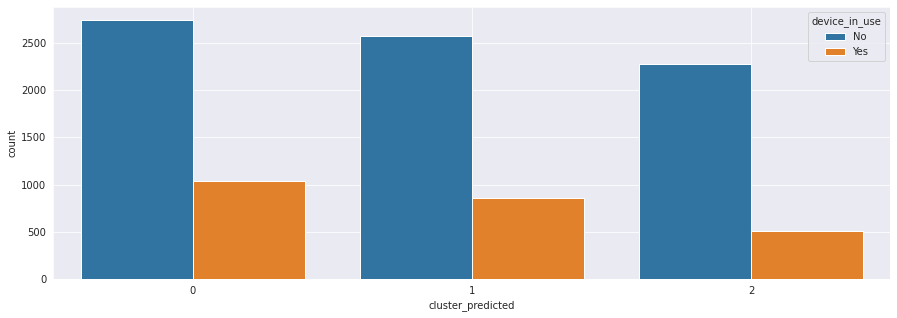

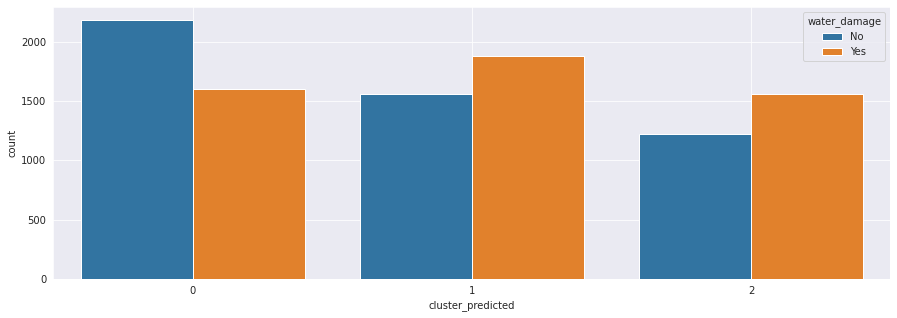

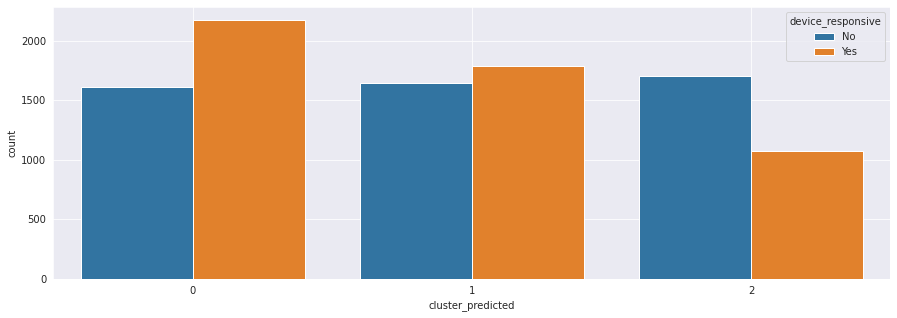

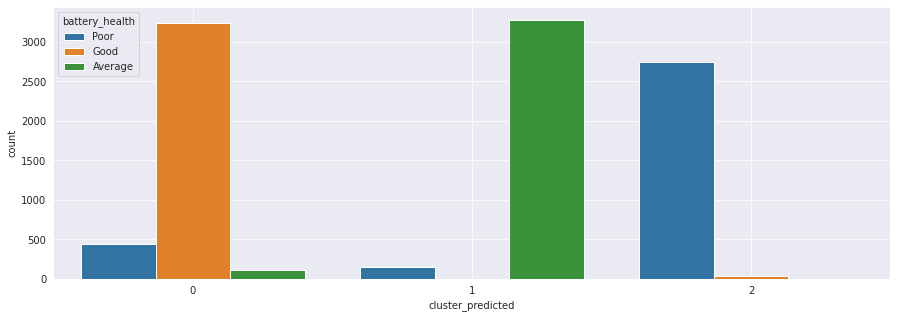

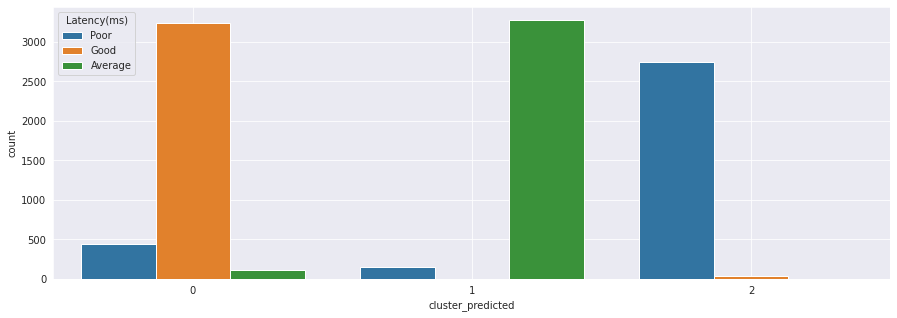

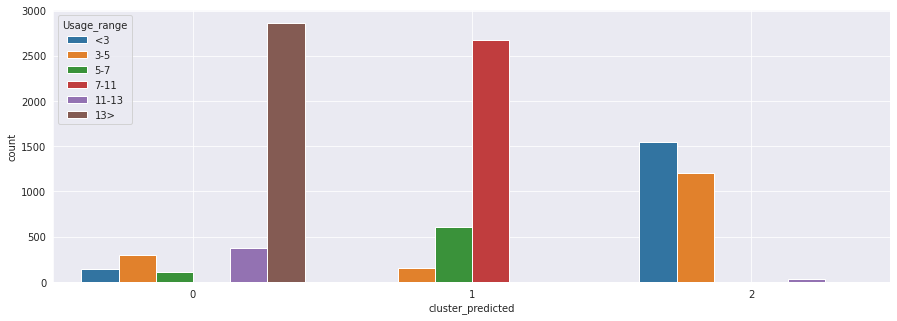

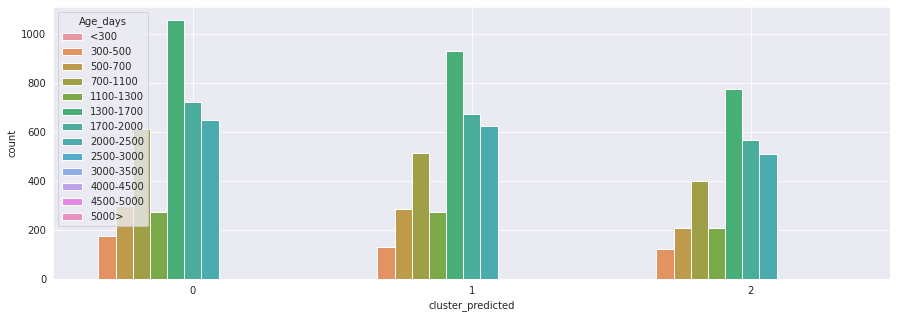

In [31]:
for col in all_features:
    plt.subplots(figsize = (15,5))
    sns.countplot(x='cluster_predicted',hue=col, data = combinedDf)
    plt.grid(True)
    plt.show()

In [32]:
#end